In [1]:
assay_index = 12

In [2]:
import pandas as pd
!gsutil cp gs://chem_dsrc/P0_Toxcast/Data/assay_df/*_df.csv ./

Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/335_all_assay_df.csv...
Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/NCCT_TPO_AUR_dn_df.csv...
Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/NVS_ADME_hCYP1A2_df.csv...
Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/NVS_ADME_hCYP2B6_df.csv...
/ [4 files][  4.3 MiB/  4.3 MiB]                                                
Operation completed over 4 objects/4.3 MiB.                                      


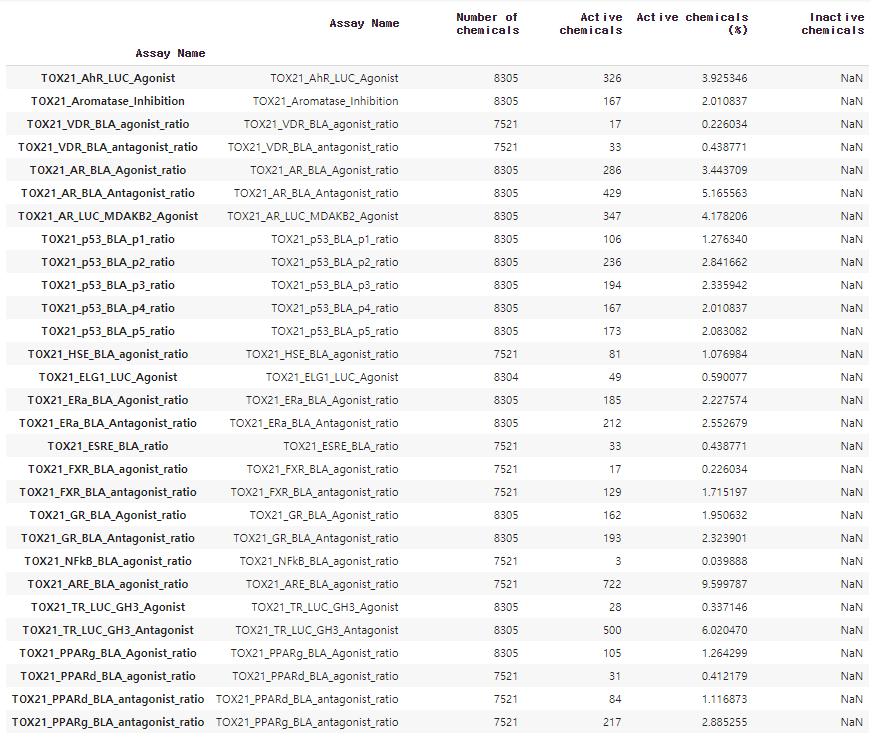

In [3]:
selected_assay_list = ['TOX21_AhR_LUC_Agonist', 'TOX21_Aromatase_Inhibition', 'TOX21_VDR_BLA_agonist_ratio', 'TOX21_VDR_BLA_antagonist_ratio', 'TOX21_AR_BLA_Agonist_ratio', 'TOX21_AR_BLA_Antagonist_ratio', 'TOX21_AR_LUC_MDAKB2_Agonist', 'TOX21_p53_BLA_p1_ratio', 'TOX21_p53_BLA_p2_ratio', 'TOX21_p53_BLA_p3_ratio', 'TOX21_p53_BLA_p4_ratio', 'TOX21_p53_BLA_p5_ratio', 'TOX21_HSE_BLA_agonist_ratio', 'TOX21_ELG1_LUC_Agonist', 'TOX21_ERa_BLA_Agonist_ratio', 'TOX21_ERa_BLA_Antagonist_ratio', 'TOX21_ESRE_BLA_ratio', 'TOX21_FXR_BLA_agonist_ratio', 'TOX21_FXR_BLA_antagonist_ratio', 'TOX21_GR_BLA_Agonist_ratio', 'TOX21_GR_BLA_Antagonist_ratio', 'TOX21_NFkB_BLA_agonist_ratio', 'TOX21_ARE_BLA_agonist_ratio', 'TOX21_TR_LUC_GH3_Agonist', 'TOX21_TR_LUC_GH3_Antagonist', 'TOX21_PPARg_BLA_Agonist_ratio', 'TOX21_PPARd_BLA_agonist_ratio', 'TOX21_PPARd_BLA_antagonist_ratio', 'TOX21_PPARg_BLA_antagonist_ratio']

In [4]:
selected_assay_list.remove('TOX21_NFkB_BLA_agonist_ratio') #active물질 개수가 3개뿐인 assay라 모델 

In [5]:
assay_name = '335_all_assay'
df = pd.read_csv(assay_name+"_df.csv")

In [6]:
df

,Unnamed: 0,TOX21_AhR_LUC_Agonist,smiles,TOX21_Aromatase_Inhibition,TOX21_VDR_BLA_agonist_ratio,TOX21_VDR_BLA_antagonist_ratio,ATG_Ahr_CIS_up,NVS_ADME_hCYP2C19,NVS_ADME_hCYP19A1,NVS_ADME_hCYP2C9,NVS_ADME_hCYP1A1,NVS_ADME_hCYP1A2,NVS_ADME_hCYP3A4,NVS_ADME_hCYP2B6,NVS_ADME_hCYP2D6,NVS_ADME_hCYP2A6,NVS_ADME_hCYP4F12,NVS_ADME_rCYP2C12,TOX21_AR_BLA_Agonist_ratio,TOX21_AR_BLA_Antagonist_ratio,TOX21_AR_LUC_MDAKB2_Agonist,ATG_AR_TRANS_up,OT_AR_ARELUC_AG_1440,OT_AR_ARSRC1_0480,OT_AR_ARSRC1_0960,NVS_NR_rAR,NVS_NR_hAR,TOX21_p53_BLA_p1_ratio,TOX21_p53_BLA_p2_ratio,TOX21_p53_BLA_p3_ratio,TOX21_p53_BLA_p4_ratio,TOX21_p53_BLA_p5_ratio,TOX21_HSE_BLA_agonist_ratio,TOX21_ELG1_LUC_Agonist,ATG_p53_CIS_up,ATG_E2F_CIS_up,ATG_HSE_CIS_up,ATG_Myb_CIS_up,ATG_Myc_CIS_up,BSK_BE3C_uPA_down,...,NVS_GPCR_rAdra1B,NVS_GPCR_r5HT_NonSelective,NVS_GPCR_r5HT1_NonSelective,NVS_GPCR_hAdra2A,NVS_GPCR_hH1,NVS_ENZ_hPTPN11,NVS_GPCR_hAdoRA2a,NVS_GPCR_hAdrb3,NVS_GPCR_rNK3,NVS_LGIC_rNNR_BungSens,NVS_GPCR_hM1,NVS_ENZ_hPDE10,NVS_ENZ_hPTPN12,NVS_GPCR_rAdra2_NonSelective,NVS_GPCR_hAdrb2,NVS_GPCR_hDRD4.4,NVS_TR_rNET,NVS_TR_hAdoT,NVS_ENZ_hPTPN13,NVS_GPCR_rSST,NVS_GPCR_hLTB4_BLT1,NVS_GPCR_hAT1,NVS_LGIC_bGABARa1,NVS_LGIC_h5HT3,NVS_GPCR_rAdrb_NonSelective,NVS_ENZ_hTrkA,NVS_LGIC_rGABAR_NonSelective,NVS_GPCR_bDR_NonSelective,NVS_GPCR_rV1,NVS_LGIC_hNNR_NBungSens,TOX21_PPARg_BLA_Agonist_ratio,TOX21_PPARd_BLA_agonist_ratio,TOX21_PPARd_BLA_antagonist_ratio,TOX21_PPARg_BLA_antagonist_ratio,ATG_PPARa_TRANS_up,ATG_PPRE_CIS_up,ATG_PPARd_TRANS_up,ATG_PPARg_TRANS_up,NVS_NR_hPPARg,NVS_NR_hPPARa
0,100-00-5,N,[O-][N+](=O)C1=CC=C(Cl)C=C1,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,N,...,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,N,N,NaN
1,1000-05-1,N,C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,N,N,N,N,N,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,N,NaN,NaN
2,10001-13-5,N,CN1CCN(CC1)C(=O)C1CCCCC1,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN
3,100-01-6,N,NC1=CC=C(C=C1)[N+]([O-])=O,N,N,N,N,6.449239794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.086069804,NaN,NaN,N,N,N,N,N,N,N,NaN,NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,N,NaN,NaN
4,100-02-7,N,OC1=CC=C(C=C1)[N+]([O-])=O,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,N,N,N,NaN,NaN,0.000103442,N,0.000122936,N,N,N,N,NaN,NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,N,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9219,NOCAS_903892,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,NaN,NaN
9220,NOCAS_903893,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N,N,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [7]:
ss = selected_assay_list[assay_index] # 그룹
a_i = 0 # assay index
ffpp = "maccs"

In [8]:
# rdkit 2020.03.3 버전 다운로드
!pip install kora -q
import kora.install.rdkit
!pip install pycaret
from pycaret.classification import *
import numpy
import pandas
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys

     |████████████████████████████████| 61kB 2.9MB/s 
     |████████████████████████████████| 61kB 3.8MB/s 
     |████████████████████████████████| 266kB 5.6MB/s 
     |████████████████████████████████| 81kB 3.9MB/s 
     |████████████████████████████████| 14.2MB 328kB/s 
     |████████████████████████████████| 61kB 5.8MB/s 
     |████████████████████████████████| 102kB 8.4MB/s 
     |████████████████████████████████| 276kB 48.8MB/s 
     |████████████████████████████████| 2.0MB 50.6MB/s 
     |████████████████████████████████| 215kB 56.3MB/s 
     |████████████████████████████████| 245kB 42.8MB/s 
     |████████████████████████████████| 1.7MB 43.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.8MB 46.1MB/s 
     |████████████████████████████████| 1.2MB 49.0MB/s 
     |████████████████████████████████| 378kB 45.9MB/s 
 

In [9]:
from pycaret.utils import enable_colab
enable_colab() #to display interactive visuals.

Colab mode enabled.


In [10]:
df_ss = df.loc[:,['smiles',ss]]
df_ss = df_ss.dropna()

In [11]:
assays_ss = df_ss.columns

In [12]:
assays_ss

Index(['smiles', 'TOX21_HSE_BLA_agonist_ratio'], dtype='object')

In [13]:
from imblearn.combine import SMOTEENN 
sme = SMOTEENN(random_state=42,sampling_strategy = "minority")

In [14]:
ss

'TOX21_HSE_BLA_agonist_ratio'

In [15]:
#Smiles --> MACCS Keys
assay = ss
df_train  = df_ss[['smiles',ss] ]

smiles_list = []
err_smiles = []# fingerfrint로 변환시 에러 smiles
fps = []
enc_y = []
for index, row in df_train.iterrows():

  if row[-1] == 'N' : 
    target = 0
  else :
    target = 1

  try : 
    mol = Chem.MolFromSmiles(row['smiles'])
    
    if ffpp == 'maccs' :    
        fp = MACCSkeys.GenMACCSKeys(mol)
    elif ffpp == 'morgan' : 
        fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    elif ffpp == 'rdkit' : 
        fp = Chem.RDKFingerprint(mol)
    elif ffpp == 'pattern' : 
        fp = Chem.rdmolops.PatternFingerprint(mol)
    elif ffpp == 'layerd' : 
        fp = Chem.rdmolops.LayeredFingerprint(mol)
    else : 
        print("fingerfrint selection error!")
        
    smiles_list.append(row['smiles'])   
    fps.append(fp)
    enc_y.append(target)
  except : 
    err_smiles.append(row['smiles'])
    pass

np_fps = []
for fp in fps:
  arr = numpy.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp, arr)
  np_fps.append(arr)

np_fps_array = numpy.array(np_fps)

print("변환 에러난 smiles 개수 : ", len(err_smiles), err_smiles)

x_train_res, y_train_res = np_fps_array, np.array(enc_y)
train = pd.DataFrame(data=x_train_res)
train['label'] = y_train_res

변환 에러난 smiles 개수 :  7 ['[F-][B+3]([F-])([F-])[F-].CC[N+]1(C)CCCC1', 'CC1C=C[C-](=C1)[Mn+]([C-]#[O+])([C-]#[O+])[C-]#[O+]', '[O-]1N2C=CC=CC2=[S][Zn++]11[O-]N2C=CC=CC2=[S]1', '[H][N]([H])([H])[Pt++]([Cl-])([Cl-])[N]([H])([H])[H]', '[Na+].[Na+].F[Si--](F)(F)(F)(F)F', '[H][N]([H])([H])[Pt++]1([O-]C(=O)C2(CCC2)C(=O)[O-]1)[N]([H])([H])[H]', 'C[Sn](C)(|[O]C(=O)CCCCCC(C)(C)C)|[O]C(=O)CCCCCC(C)(C)C']


In [16]:
d = pd.DataFrame(columns = ['smiles','Type'] )
d['smiles'] = smiles_list
d['Type'] = enc_y

In [17]:
d

,smiles,Type
0,[O-][N+](=O)C1=CC=C(Cl)C=C1,0
1,C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C,0
2,CN1CCN(CC1)C(=O)C1CCCCC1,0
3,NC1=CC=C(C=C1)[N+]([O-])=O,0
4,OC1=CC=C(C=C1)[N+]([O-])=O,0
...,...,...
7355,FC1=CC(Br)=C(C=C1)C(=O)NS(=O)(=O)\C=C\C1=CC=CS1,0
7356,OC(=O)C(F)(F)F.CCN(CC)C(=O)C1=C(C=C(N2CCC(CC2)...,0
7357,CC(=O)NC1=NC(=O)N(C=C1)C1COC(COC(=O)C2=CC=CC=C...,0
7358,OC(=O)\C=C\C(O)=O.CCN(CC)CCC1=CNC2=CC=CC=C12.C...,0


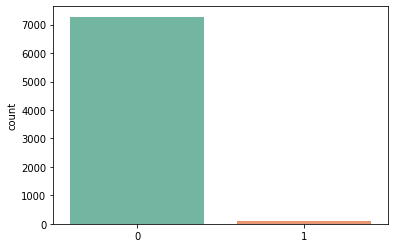

In [18]:
import seaborn as sns
sns.countplot(enc_y, palette="Set2") #팔레트를 이렇게 바꿀수 있구나.

In [19]:
#모든 물질에 대한 fingerprint를 string형태로 바꾼다(비교하기위함).
mychems = []
for item in np_fps:
    #print(item)
    item = np.array(item,dtype=int) #왜 굳이 두번? int형으로 추가하려면 이렇게 하면 되는구나....
    s = item.tolist() #넘파이어레이를 리스트로 바꾼다. 
    t = [str(i) for i in s]
    mychems.append(''.join(t))

In [20]:
i = 0
counter = 0
chemdict = {} #딗셔너리.
listofdups = []
for item in mychems:
    try:
        chemdict[str(item)].append(i)
        #print('dup found')
        for j in range(len(chemdict[str(item)])):
            if (d['Type'][i] != d['Type'][chemdict[str(item)][j]]) :
                listofdups.append(i)
                counter+=1
    except: 
        #print('adding new')
        chemdict[str(item)] = []
        chemdict[str(item)].append(i)
    i+=1
print(str(counter)+' '+str(len(list(set(listofdups)))))
#smote적용하기 전에서 listofdups를 빼면 된다!


41 35


In [21]:
dups_list = list(set(listofdups))

In [22]:
dups_list # 0인것만 지우는게 맞나?

[2562,
 5894,
 524,
 6668,
 6798,
 1679,
 4503,
 6301,
 798,
 2592,
 6819,
 5031,
 4392,
 4148,
 2873,
 6588,
 4798,
 2373,
 6862,
 6863,
 721,
 6865,
 6101,
 6878,
 5983,
 4840,
 4201,
 2795,
 5995,
 7277,
 6516,
 5366,
 761,
 5373,
 6782]

In [23]:
dups_list_0 = []
for index in dups_list : 
  if train.iloc[index].label == 0 :
    dups_list_0.append(index)

In [24]:
train = train.drop(dups_list_0)

In [25]:
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [26]:
len(smiles_list)

7360

In [27]:
duplicated_smiles_0_df = pd.DataFrame()
duplicated_smiles_0_df['deleted_duplicate_smiles_0'] = smiles_list
duplicated_smiles_0_df = duplicated_smiles_0_df.iloc[dups_list_0,]
duplicated_smiles_0_df

,deleted_duplicate_smiles_0
2562,C1=CC=C2C=C3C4=CC=CC=C4C4=CC=CC=C4C3=CC2=C1
524,BrC1=CC=CC=C1
6668,CCCCCCCCC=C
6798,CC1=CC(C)=C(C=C1)[N+]([O-])=O
4503,C1=CC2=CC=C3C=C4C(C=CC5=CC=CC=C45)=CC3=C2C=C1
798,CCCCCCCCCCCCCCCCC=C
2592,C1=CC2=C(C=C1)C1=C(C=C2)C2=C(C=CC=C2)C=C1
6819,CC1=C2C=CC=CC2=CC=C1
5031,O.O.[Zn++].CC([O-])=O.CC([O-])=O
2873,N#CC1=CC2=C(C=CC=C2)C2=C1C=CC=C2


In [28]:
save_path = 'gs://chem_dsrc/P0_Toxcast/result/29assays_dd/'

In [29]:
dupdf = ss+"_dup_smiles_df.csv"
duplicated_smiles_0_df.to_csv(dupdf)
duppath = save_path + 'err_smiles/'
!gsutil cp $dupdf $duppath

Copying file://TOX21_HSE_BLA_agonist_ratio_dup_smiles_df.csv [Content-Type=text/csv]...
/ [1 files][  870.0 B/  870.0 B]                                                
Operation completed over 1 objects/870.0 B.                                      


In [30]:
import pandas as pd
err_smiles_df = pd.DataFrame(columns = [ss], index = ['err_n','err_smiles'])
err_smiles_df[ss] = [ len(err_smiles), err_smiles]

In [31]:
ersdf = ss+"_err_smiles_df.csv"
err_smiles_df.to_csv(ersdf)
errpath = save_path + 'err_smiles/'
!gsutil cp $ersdf $errpath $errpath

Copying file://TOX21_HSE_BLA_agonist_ratio_err_smiles_df.csv [Content-Type=text/csv]...
Omitting prefix "gs://chem_dsrc/P0_Toxcast/result/29assays_dd/err_smiles/". (Did you mean to do cp -r?)

Operation completed over 1 objects/423.0 B.                                      


In [32]:
err_smiles_df

,TOX21_HSE_BLA_agonist_ratio
err_n,7
err_smiles,"[[F-][B+3]([F-])([F-])[F-].CC[N+]1(C)CCCC1, CC..."


In [33]:
# clf = setup(data = train, target = 'label') 
clf = setup(data = train, target = 'label', fix_imbalance = True, fix_imbalance_method = sme
            ,train_size = 0.9
            ,use_gpu =True
            ,session_id=123) 

,Description,Value
0,session_id,123
1,Target,label
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(7333, 168)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,163
8,Ordinal Features,False
9,High Cardinality Features,False


# RF - default parameter

In [34]:
save_path_m = save_path+'/rf/'

In [35]:
rf = create_model('rf')
rf_df = pull()
rf_df_name = "rf_df_"+ss+".csv"
rf_df.to_csv(rf_df_name)
rf_df_path = save_path_m+ss+"/"
!gsutil cp $rf_df_name $rf_df_path

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9833,0.8267,0.2857,0.2500,0.2667,0.2583,0.2589
1,0.9894,0.8542,0.2857,0.5000,0.3636,0.3587,0.3731
2,0.9939,0.8865,0.5714,0.8000,0.6667,0.6637,0.6733
3,0.9833,0.6810,0.0000,0.0000,0.0000,-0.0078,-0.0081
4,0.9818,0.7637,0.2857,0.2222,0.2500,0.2409,0.2429
5,0.9864,0.7537,0.1429,0.2500,0.1818,0.1755,0.1825
6,0.9864,0.8063,0.2500,0.4000,0.3077,0.3012,0.3097
7,0.9788,0.6611,0.1250,0.1250,0.1250,0.1143,0.1143
8,0.9879,0.7780,0.2500,0.5000,0.3333,0.3279,0.3481
9,0.9909,0.7698,0.4286,0.6000,0.5000,0.4955,0.5027


Copying file://rf_df_TOX21_HSE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  613.0 B/  613.0 B]                                                
Operation completed over 1 objects/613.0 B.                                      


In [36]:
predict_model(rf)
rf_p_df = pull()
rf_p_df_name = "rf_p_df_"+ss+".csv"
rf_p_df.to_csv(rf_p_df_name)
rf_p_df_path = save_path_m+ss+"/"
!gsutil cp $rf_p_df_name $rf_p_df_path

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9796,0.5989,0.0,0.0,0.0,-0.0103,-0.0103


Copying file://rf_p_df_TOX21_HSE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  115.0 B/  115.0 B]                                                
Operation completed over 1 objects/115.0 B.                                      


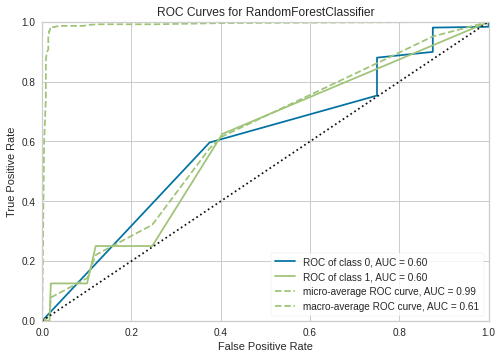

In [ ]:
plot_model(rf, plot = 'auc')

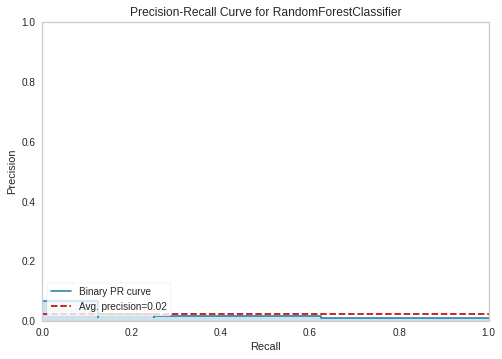

In [ ]:
plot_model(rf, plot = 'pr')

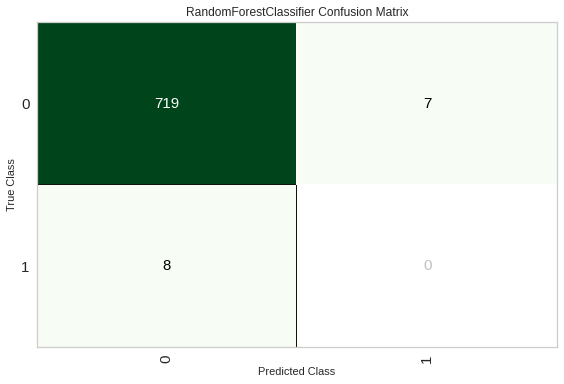

In [ ]:
plot_model(rf, plot = 'confusion_matrix')

In [ ]:
print(rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


# RF - tuned parameter by AUC

In [ ]:
tuned_rf_auc = tune_model(rf, optimize = 'AUC')
tuned_rf_auc_df = pull()
tuned_rf_auc_df_name = "tuned_rf_auc_df_"+ss+".csv"
tuned_rf_auc_df.to_csv(tuned_rf_auc_df_name)
tuned_rf_auc_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_auc_df_name $tuned_rf_auc_df_path

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8864,0.6885,0.2857,0.0278,0.0506,0.0319,0.0587
1,0.9030,0.7775,0.4286,0.0476,0.0857,0.0679,0.1174
2,0.9182,0.8937,0.7143,0.0877,0.1562,0.1400,0.2314
3,0.9030,0.6115,0.1429,0.0169,0.0303,0.0116,0.0194
4,0.8803,0.7699,0.4286,0.0385,0.0706,0.0521,0.0995
5,0.9091,0.7598,0.5714,0.0656,0.1176,0.1005,0.1712
6,0.9106,0.8875,0.5000,0.0678,0.1194,0.1002,0.1594
7,0.9121,0.7124,0.5000,0.0690,0.1212,0.1021,0.1612
8,0.9076,0.7905,0.6250,0.0794,0.1408,0.1220,0.1996
9,0.9150,0.6549,0.2857,0.0377,0.0667,0.0488,0.0782


Copying file://tuned_rf_auc_df_TOX21_HSE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  641.0 B/  641.0 B]                                                
Operation completed over 1 objects/641.0 B.                                      


In [ ]:
predict_model(tuned_rf_auc)
tuned_rf_auc_p_df = pull()
tuned_rf_auc_p_df_name = "tuned_rf_auc_p_df_"+ss+".csv"
tuned_rf_auc_p_df.to_csv(tuned_rf_auc_p_df_name)
tuned_rf_auc_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_auc_p_df_name $tuned_rf_auc_p_df_path

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9101,0.8014,0.5,0.0606,0.1081,0.0904,0.1505


Copying file://tuned_rf_auc_p_df_TOX21_HSE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  119.0 B/  119.0 B]                                                
Operation completed over 1 objects/119.0 B.                                      


# RF -tuned parameter by F1

In [ ]:
tuned_rf_f1 = tune_model(rf, optimize = 'F1')
tuned_rf_f1_df = pull()
tuned_rf_f1_df_name = "tuned_rf_f1_df_"+ss+".csv"
tuned_rf_f1_df.to_csv(tuned_rf_f1_df_name)
tuned_rf_f1_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_f1_df_name $tuned_rf_f1_df_path

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8864,0.6885,0.2857,0.0278,0.0506,0.0319,0.0587
1,0.9030,0.7775,0.4286,0.0476,0.0857,0.0679,0.1174
2,0.9182,0.8937,0.7143,0.0877,0.1562,0.1400,0.2314
3,0.9030,0.6115,0.1429,0.0169,0.0303,0.0116,0.0194
4,0.8803,0.7699,0.4286,0.0385,0.0706,0.0521,0.0995
5,0.9091,0.7598,0.5714,0.0656,0.1176,0.1005,0.1712
6,0.9106,0.8875,0.5000,0.0678,0.1194,0.1002,0.1594
7,0.9121,0.7124,0.5000,0.0690,0.1212,0.1021,0.1612
8,0.9076,0.7905,0.6250,0.0794,0.1408,0.1220,0.1996
9,0.9150,0.6549,0.2857,0.0377,0.0667,0.0488,0.0782


Copying file://tuned_rf_f1_df_TOX21_HSE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  641.0 B/  641.0 B]                                                
Operation completed over 1 objects/641.0 B.                                      


In [ ]:
predict_model(tuned_rf_f1)
tuned_rf_f1_p_df = pull()
tuned_rf_f1_p_df_name = "tuned_rf_f1_p_df_"+ss+".csv"
tuned_rf_f1_p_df.to_csv(tuned_rf_f1_p_df_name)
tuned_rf_f1_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_f1_p_df_name $tuned_rf_f1_p_df_path

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9101,0.8014,0.5,0.0606,0.1081,0.0904,0.1505


Copying file://tuned_rf_f1_p_df_TOX21_HSE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  119.0 B/  119.0 B]                                                
Operation completed over 1 objects/119.0 B.                                      


# RF -tuned parameter by Kappa

In [ ]:
tuned_rf_kappa = tune_model(rf, optimize = 'Kappa')
tuned_rf_kappa_df = pull()
tuned_rf_kappa_df_name = "tuned_rf_kappa_df_"+ss+".csv"
tuned_rf_kappa_df.to_csv(tuned_rf_kappa_df_name)
tuned_rf_kappa_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_kappa_df_name $tuned_rf_kappa_df_path

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8864,0.6885,0.2857,0.0278,0.0506,0.0319,0.0587
1,0.9030,0.7775,0.4286,0.0476,0.0857,0.0679,0.1174
2,0.9182,0.8937,0.7143,0.0877,0.1562,0.1400,0.2314
3,0.9030,0.6115,0.1429,0.0169,0.0303,0.0116,0.0194
4,0.8803,0.7699,0.4286,0.0385,0.0706,0.0521,0.0995
5,0.9091,0.7598,0.5714,0.0656,0.1176,0.1005,0.1712
6,0.9106,0.8875,0.5000,0.0678,0.1194,0.1002,0.1594
7,0.9121,0.7124,0.5000,0.0690,0.1212,0.1021,0.1612
8,0.9076,0.7905,0.6250,0.0794,0.1408,0.1220,0.1996
9,0.9150,0.6549,0.2857,0.0377,0.0667,0.0488,0.0782


Copying file://tuned_rf_kappa_df_TOX21_HSE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  641.0 B/  641.0 B]                                                
Operation completed over 1 objects/641.0 B.                                      


In [ ]:
predict_model(tuned_rf_kappa)
tuned_rf_kappa_p_df = pull()
tuned_rf_kappa_p_df_name = "tuned_rf_kappa_p_df_"+ss+".csv"
tuned_rf_kappa_p_df.to_csv(tuned_rf_kappa_p_df_name)
tuned_rf_kappa_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_kappa_p_df_name $tuned_rf_kappa_p_df_path

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9101,0.8014,0.5,0.0606,0.1081,0.0904,0.1505


Copying file://tuned_rf_kappa_p_df_TOX21_HSE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  119.0 B/  119.0 B]                                                
Operation completed over 1 objects/119.0 B.                                      


# RF -tuned parameter by MCC

In [ ]:
tuned_rf_MCC = tune_model(rf, optimize = 'MCC')
tuned_rf_MCC_df = pull()
tuned_rf_MCC_df_name = "tuned_rf_MCC_df_"+ss+".csv"
tuned_rf_MCC_df.to_csv(tuned_rf_MCC_df_name)
tuned_rf_MCC_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_MCC_df_name $tuned_rf_MCC_df_path

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8864,0.6885,0.2857,0.0278,0.0506,0.0319,0.0587
1,0.9030,0.7775,0.4286,0.0476,0.0857,0.0679,0.1174
2,0.9182,0.8937,0.7143,0.0877,0.1562,0.1400,0.2314
3,0.9030,0.6115,0.1429,0.0169,0.0303,0.0116,0.0194
4,0.8803,0.7699,0.4286,0.0385,0.0706,0.0521,0.0995
5,0.9091,0.7598,0.5714,0.0656,0.1176,0.1005,0.1712
6,0.9106,0.8875,0.5000,0.0678,0.1194,0.1002,0.1594
7,0.9121,0.7124,0.5000,0.0690,0.1212,0.1021,0.1612
8,0.9076,0.7905,0.6250,0.0794,0.1408,0.1220,0.1996
9,0.9150,0.6549,0.2857,0.0377,0.0667,0.0488,0.0782


Copying file://tuned_rf_MCC_df_TOX21_HSE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  641.0 B/  641.0 B]                                                
Operation completed over 1 objects/641.0 B.                                      


In [ ]:
predict_model(tuned_rf_MCC)
tuned_rf_MCC_p_df = pull()
tuned_rf_MCC_p_df_name = "tuned_rf_MCC_p_df_"+ss+".csv"
tuned_rf_MCC_p_df.to_csv(tuned_rf_MCC_p_df_name)
tuned_rf_MCC_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_MCC_p_df_name $tuned_rf_MCC_p_df_path

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9101,0.8014,0.5,0.0606,0.1081,0.0904,0.1505


Copying file://tuned_rf_MCC_p_df_TOX21_HSE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  119.0 B/  119.0 B]                                                
Operation completed over 1 objects/119.0 B.                                      


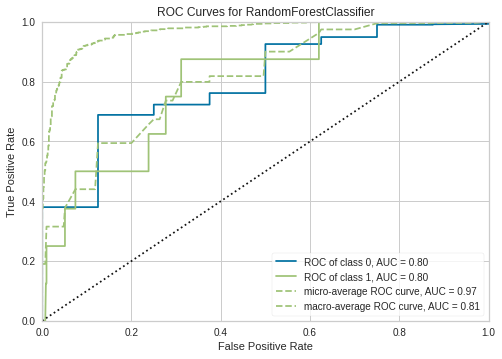

In [ ]:
plot_model(tuned_rf_auc, plot = 'auc')

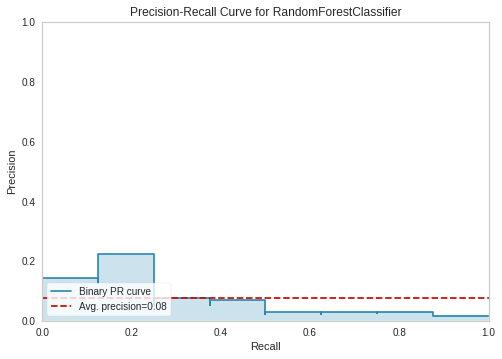

In [ ]:
plot_model(tuned_rf_auc, plot = 'pr')

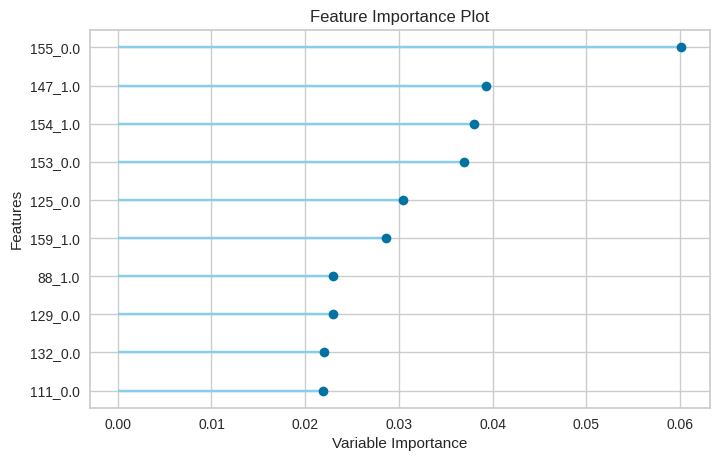

In [ ]:
plot_model(tuned_rf_auc, plot='feature')

In [ ]:
print(tuned_rf_auc)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=190, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


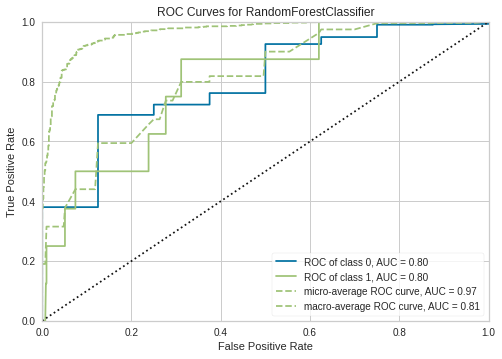

In [ ]:
plot_model(tuned_rf_f1, plot = 'auc')

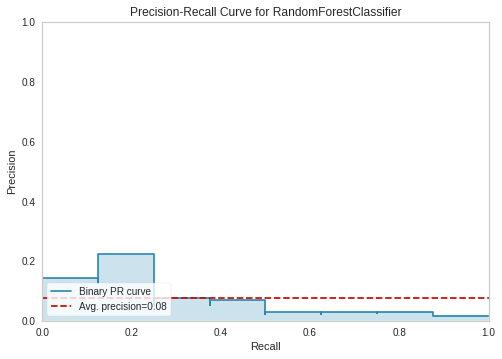

In [ ]:
plot_model(tuned_rf_f1, plot = 'pr')

In [ ]:
plot_model(tuned_rf_f1, plot='feature')

In [ ]:
print(tuned_rf_f1)

In [ ]:
plot_model(tuned_rf_kappa, plot = 'auc')

In [ ]:
plot_model(tuned_rf_kappa, plot = 'pr')

In [ ]:
plot_model(tuned_rf_kappa, plot='feature')

In [ ]:
print(tuned_rf_kappa)

In [ ]:
plot_model(tuned_rf_MCC, plot = 'auc')

In [ ]:
plot_model(tuned_rf_MCC, plot = 'pr')

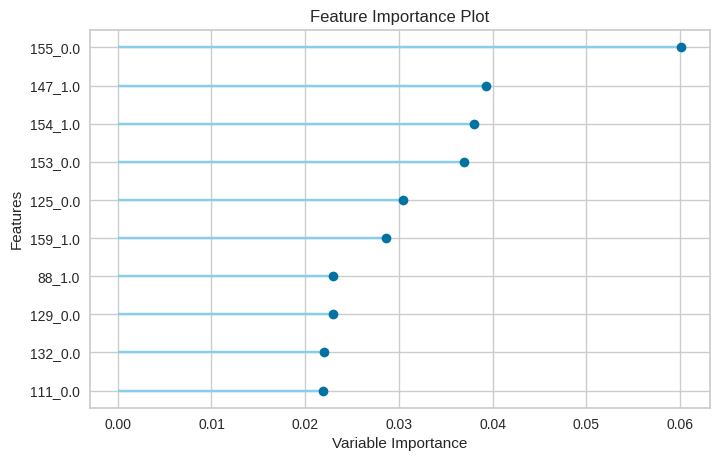

In [ ]:
plot_model(tuned_rf_MCC, plot='feature')

In [ ]:
print(tuned_rf_MCC)

# all algorithm compare with validation auc

In [ ]:
best_specific = compare_models (sort = 'AUC', n_select = 6)
allml_df = pull()
allml_df_name = "allml_df_"+ss+".csv"
allml_df.to_csv(allml_df_name)
allml_df_path save_path+"allml/"+ss+"/"
!gsutil cp $allml_df_name $allml_df_path